In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product e.csv', parse_dates=['Month-Year'])


In [3]:
sales_e= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_e = sales_e.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_e.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,57650,303130,2978499
1,2019-02-01,66035,347219,3411712
2,2019-03-01,88208,463807,4557285
3,2019-04-01,74712,392844,3860011
4,2019-05-01,61172,321649,3160464


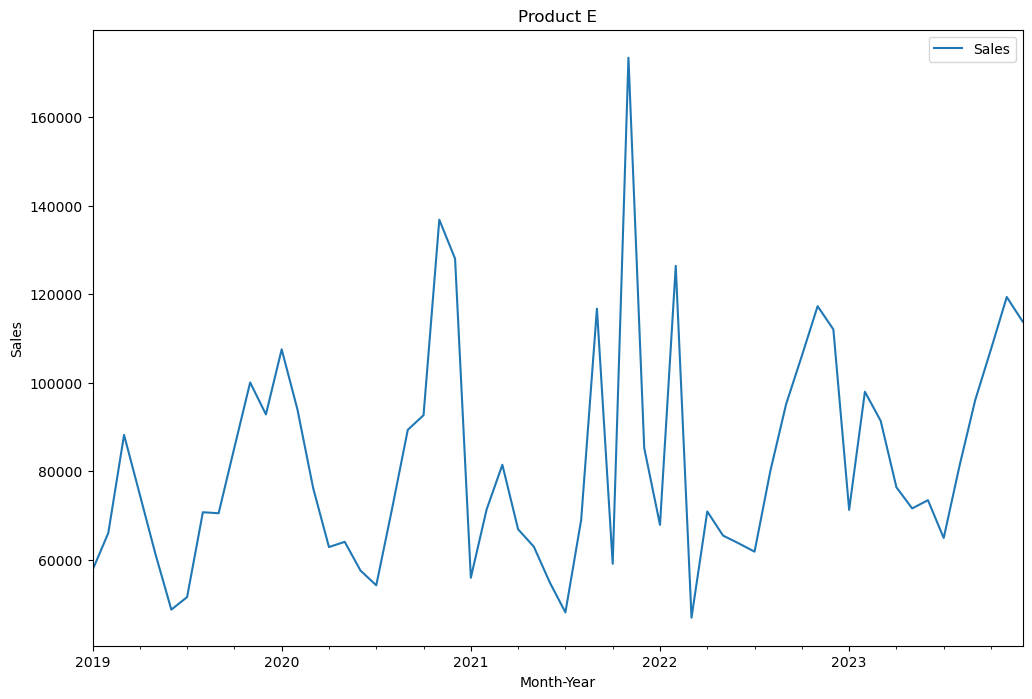

In [5]:
ax = sales_e.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product E')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_e[:48]
test=sales_e[48:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

22:17:18 - cmdstanpy - INFO - Chain [1] start processing
22:17:20 - cmdstanpy - INFO - Chain [1] done processing
22:17:23 - cmdstanpy - INFO - Chain [1] start processing
22:17:23 - cmdstanpy - INFO - Chain [1] done processing
22:17:25 - cmdstanpy - INFO - Chain [1] start processing
22:17:26 - cmdstanpy - INFO - Chain [1] done processing
22:17:30 - cmdstanpy - INFO - Chain [1] start processing
22:17:31 - cmdstanpy - INFO - Chain [1] done processing
22:17:33 - cmdstanpy - INFO - Chain [1] start processing
22:17:33 - cmdstanpy - INFO - Chain [1] done processing
22:17:36 - cmdstanpy - INFO - Chain [1] start processing
22:17:42 - cmdstanpy - INFO - Chain [1] done processing
22:17:48 - cmdstanpy - INFO - Chain [1] start processing
22:17:48 - cmdstanpy - INFO - Chain [1] done processing
22:17:51 - cmdstanpy - INFO - Chain [1] start processing
22:17:51 - cmdstanpy - INFO - Chain [1] done processing
22:17:57 - cmdstanpy - INFO - Chain [1] start processing
22:17:57 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   14384.309097  
1   14266.545252  
2   22276.400975  
3   16344.803870  
4   20432.817104  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
37,0.200,0.01,multiplicative,13413.170796
49,0.300,0.01,multiplicative,13427.679611
25,0.100,0.01,multiplicative,13467.067698
13,0.010,0.01,multiplicative,13694.969680
61,0.500,0.01,multiplicative,13722.643224
...,...,...,...,...
50,0.300,0.10,additive,21349.982365
26,0.100,0.10,additive,21355.515989
14,0.010,0.10,additive,21480.762577
38,0.200,0.10,additive,21490.665410


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=0.01, seasonality_mode= 'multiplicative',interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

22:22:14 - cmdstanpy - INFO - Chain [1] start processing
22:22:14 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [13]:
future_dates['Market Size'] = sales_e['Market Size']
future_dates['Marketing Expense'] = sales_e['Marketing Expense']

In [14]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,303130,2978499
1,2019-02-01,347219,3411712
2,2019-03-01,463807,4557285
3,2019-04-01,392844,3860011
4,2019-05-01,321649,3160464
5,2019-06-01,256180,2517181
6,2019-07-01,271087,2663652
7,2019-08-01,371885,3654074
8,2019-09-01,370707,3642501
9,2019-10-01,526105,5169414


In [15]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [16]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [17]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,70184.157647,29329.726815,112259.974760
49,2023-02-01,84072.541027,41571.664263,126986.949389
50,2023-03-01,80451.208205,39555.501784,122166.285894
51,2023-04-01,72728.924848,31552.330126,114107.981447
52,2023-05-01,70125.359716,30916.830471,112352.757287
53,2023-06-01,70712.404101,33228.463345,111997.986768
54,2023-07-01,66156.147885,27220.991869,107420.891950
55,2023-08-01,74502.081349,31920.671731,112006.968964
56,2023-09-01,82100.999040,39673.858865,122979.554116
57,2023-10-01,91630.515421,51911.081512,133550.143995


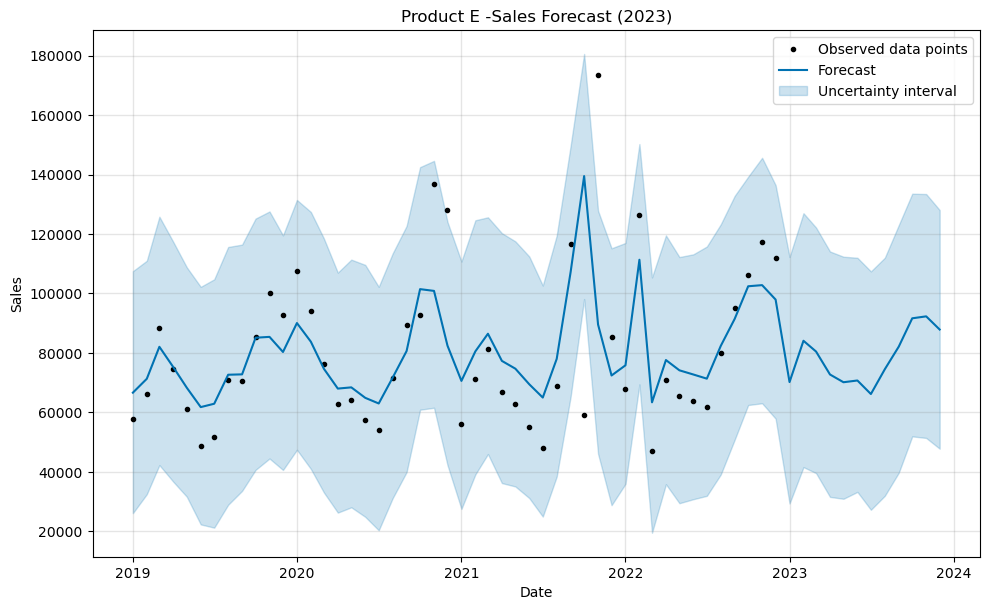

In [18]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product E -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

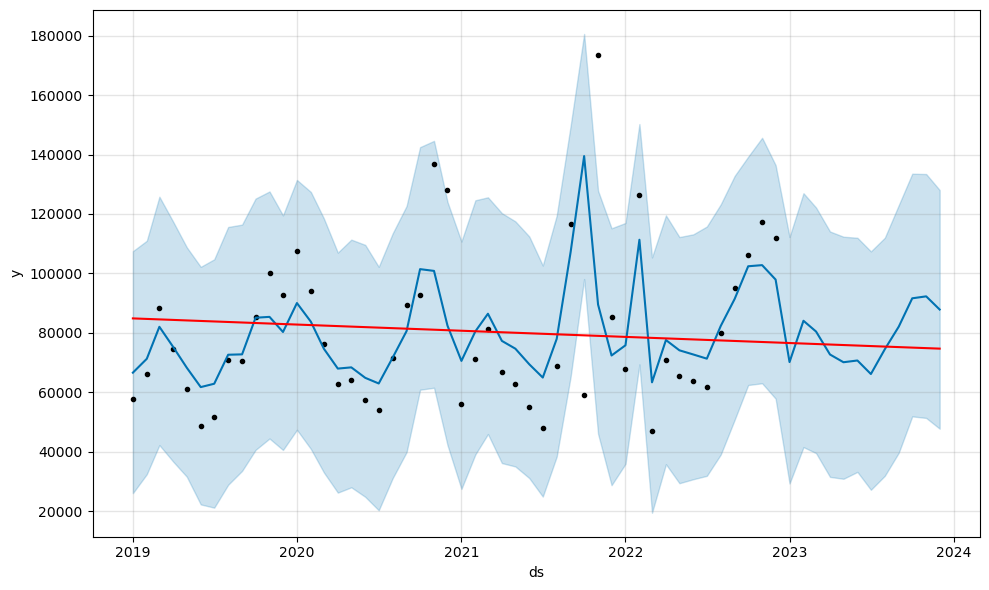

In [19]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

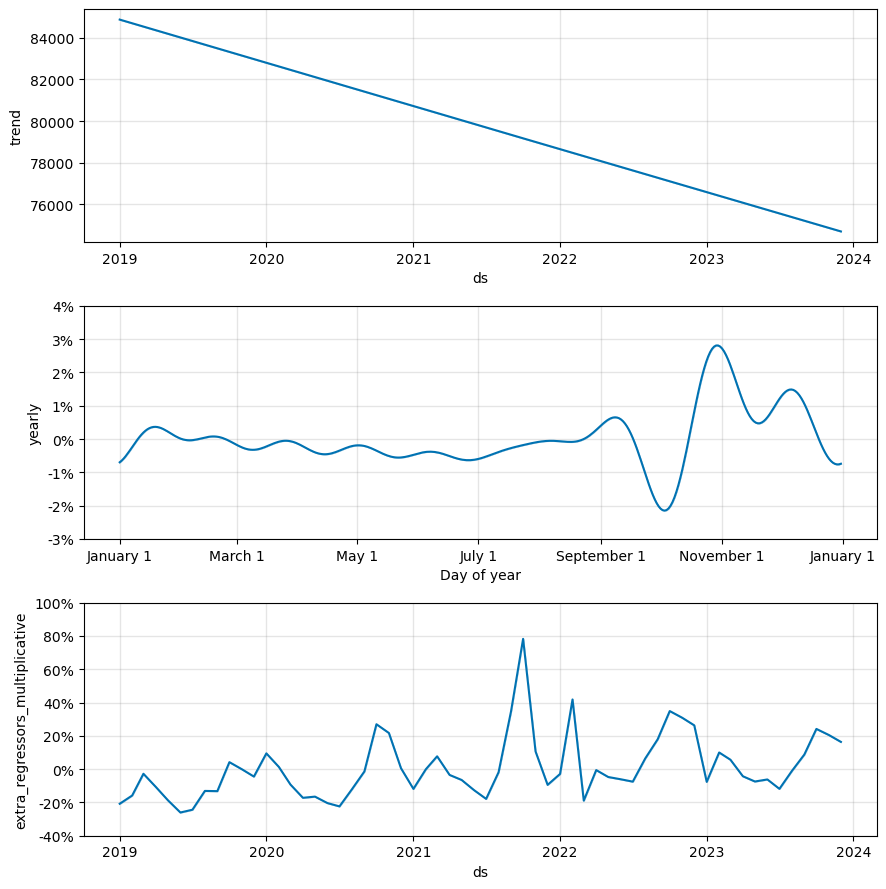

In [20]:
fig2 = model.plot_components(forecast)

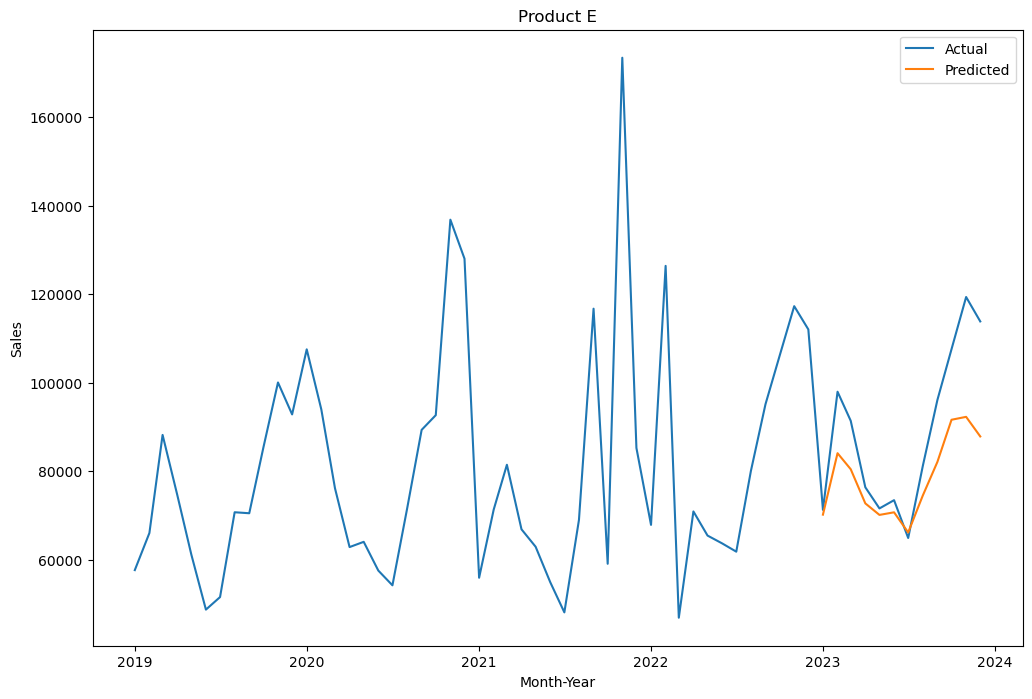

In [21]:
# Reset index of sales_b DataFrame
sales_e_reset_index = sales_e.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_e_reset_index['ds'], sales_e_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product E')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [22]:
#model evaluation

In [23]:
pred=forecasted_df['yhat']
test_df=test['y']

In [24]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 10392.564
MAPE - FB PROPHET: 0.103
MSE - FB PROPHET: 186880554.496
RMSE - FB PROPHET: 13670.426


In [25]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [26]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,9.156548e+07,9568.985533,9568.985533,0.140980,0.140980,0.131696,1.0
1,62 days,4.542054e+08,21312.095712,21312.095712,0.168594,0.168594,0.184114,1.0
2,90 days,4.381204e+08,20931.326547,20931.326547,0.446402,0.446402,0.364946,1.0
3,121 days,6.271582e+07,7919.332352,7919.332352,0.111683,0.111683,0.105776,1.0
4,151 days,1.133322e+08,10645.757792,10645.757792,0.162642,0.162642,0.150411,1.0
5,182 days,1.272612e+08,11281.008616,11281.008616,0.177132,0.177132,0.162721,1.0
6,212 days,1.453773e+08,12057.250666,12057.250666,0.195044,0.195044,0.177713,1.0
7,243 days,6.574657e+06,2564.109490,2564.109490,0.032037,0.032037,0.031532,1.0
8,274 days,2.797936e+07,5289.551566,5289.551566,0.055601,0.055601,0.057191,1.0
9,304 days,5.357094e+07,7319.216917,7319.216917,0.069002,0.069002,0.071467,1.0


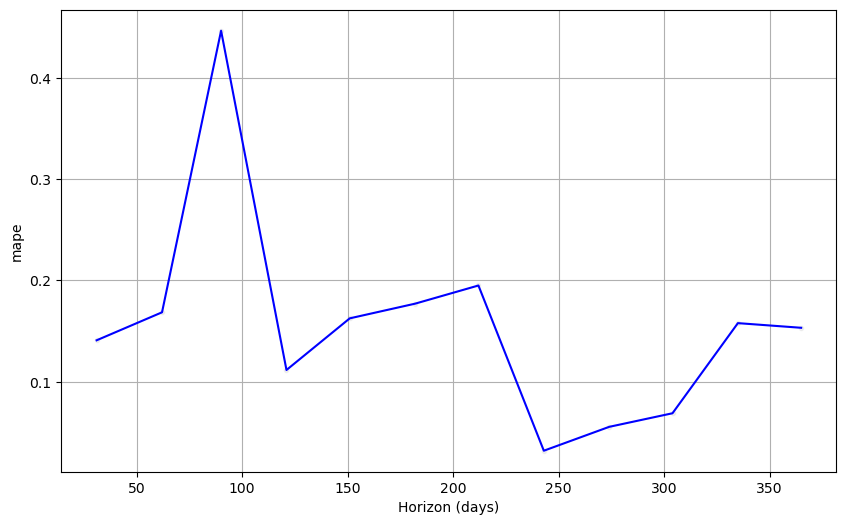

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='mape')